In [1]:
%matplotlib widget

In [2]:
from functools import partial

In [3]:
from libschrodinger.crank_nicolson_2d import *

In [4]:
from libschrodinger.potentials import *

In [5]:
from libschrodinger.campaigns import *

In [6]:
import numpy as np

In [7]:
import pandas as pd

In [8]:
from pathlib import Path

In [9]:
from typing import Dict

In [10]:
caseName : str = "profile_1"

In [11]:
math = cp
spatialStep : float = .01
length : float = 4
temporalStep : float = (spatialStep ** 2) / 4
courantNumber : float = 1.0
pointCount : int = int(length / spatialStep)
potentialHeight : float = 1000
preRegionLength = .3
preRegionScalar = 2
packetStandardDeviation : float = preRegionLength / preRegionScalar
packetStartX : float = 1 - ((preRegionScalar / 2) * packetStandardDeviation)
packetStartY : float = .5
packetWaveNumber : float = 13 * np.pi
barrierCount : int = 3
postRegionLength = .3
intraRegionLength : float = 1 - (postRegionLength + preRegionLength)
barrierWidth : float = intraRegionLength / barrierCount
constantPotentialLengthRatios : List[float] = [postRegionLength] \
        + ([barrierWidth] * barrierCount) \
        + [preRegionLength]
print("Point Count: ", pointCount)
print("Post Region Length: ", postRegionLength)
print("Intra Region Length: ", intraRegionLength)
print("Pre Region Length: ", preRegionLength)
print("Barrier Length: ", barrierWidth)
print("Total Length: ", intraRegionLength + postRegionLength + preRegionLength)
print("Total Length Ratios: ", np.sum(constantPotentialLengthRatios))
frameCount : int = 60
backend = "cupy"

Point Count:  400
Post Region Length:  0.3
Intra Region Length:  0.4
Pre Region Length:  0.3
Barrier Length:  0.13333333333333333
Total Length:  1.0
Total Length Ratios:  1.0


In [12]:
wavePacketFunction = lambda position : makeWavePacket(
            position, 
            packetStartX * length, 
            packetStartY * length, 
            spatialStep, 
            packetStandardDeviation, 
            packetWaveNumber, 
            math
        )

In [13]:
potentials : List[List[float]] = [
        [1, 1, 1, 0, 0], 
        [1 / 2, 1 / 2, 1 / 2, 0, 0], 
        [1 / 3, 1 / 3, 1 / 3, 0, 0], 
        [1 / 4, 1 / 4, 1 / 4, 0, 0], 
        [1 / 5, 1 / 5, 1 / 5, 0, 0], 
        [1 / 10, 1 / 10, 1 / 10, 0, 0]
    ]

In [14]:
profiles : List[SimulationProfile] = constantSimulationProfiles(
        wavePacketFunction, 
        spatialStep, 
        temporalStep, 
        length, 
        constantPotentialLengthRatios, 
        potentials, 
        potentialHeight, 
        pointCount, 
        True, 
        edgeBound = True, 
        logFunction = performenceLog, 
        gpuAccelerated = True, 
        math = cp
    )

In [15]:
constantPotentialLengthRatios

[0.3, 0.13333333333333333, 0.13333333333333333, 0.13333333333333333, 0.3]

In [16]:
allData, _, logs = recordConstantRegionSimulations(
        profiles, 
        frameCount, 
        caseName, 
        constantPotentialLengthRatios, 
        True, 
        constantRegionLabels = ["Post", "3rdStair", "2ndStair", "1stStair", "Pre"], 
        showBar = True, 
        showFPS = True, 
        showTotalTime = True, 
        math = cp
    )

[====================================================================================================]
[--------------------------------------------------------------------------------------------------]
Total Time:  800.174620844
Frames Per Second:  0.07365529005815084
Simulation 0 is done, processing probabilities.
Simulation 0: done processing probabilities.
Simulation 0: logging.
Saving Video of profile_10
Saving Video of Post
Saving Video of 3rdStair
Saving Video of 2ndStair
Saving Video of 1stStair
Saving Video of Pre
Done logging profile_10
Producing Simulation final output CSV
[====================================================================================================]
[--------------------------------------------------------------------------------------------------]
Total Time:  797.2229462429996
Frames Per Second:  0.07383120387738656
Simulation 1 is done, processing probabilities.
Simulation 1: done processing probabilities.
Simulation 1: logging.
Saving Video of p

In [17]:
allData["packetStartX"] = packetStartX
allData["packetStartY"] = packetStartY
allData["initialWaveNumber"] = packetWaveNumber
allData["standardDeviation"] = packetStandardDeviation

In [18]:
for key in allData: 
    allData[key] = asNumPyArray(allData[key])

In [19]:
pd.DataFrame(allData).to_csv(str(Path.cwd() / caseName / (caseName + ".csv")))

In [20]:
logKeyList = [
    'Starting "Step"',
    'Created knownStepMatrix',
    'Created unknownStepMatrix',
    'Started "Compute"',
    'Reshaped Wave Function',
    'Matrix Multiplication',
    'Solved For Independant Terms and Reshaped',
    'Appended Wave Function and Finished "Compute"',
    'Computed and Finished "Step"'
]

In [21]:
copiedLogs = []
logIndex = 0
logPath = Path.cwd() / caseName / "logs"
logPath.mkdir(exist_ok = True)
for log in logs: 
    logCopy = {}
    for key in logKeyList: 
        logCopy[key] = log[key]
    copiedLogs.append(logCopy)
    pd.DataFrame(logCopy).to_csv(str(logPath / (caseName + "_log_" + str(logIndex) + ".csv")))
    logIndex += 1

Starting "Step"
Created knownStepMatrix
Created unknownStepMatrix
Started "Compute"
Reshaped Wave Function
Matrix Multiplication
Solved For Independant Terms and Reshaped
Appended Wave Function and Finished "Compute"
Computed and Finished "Step"


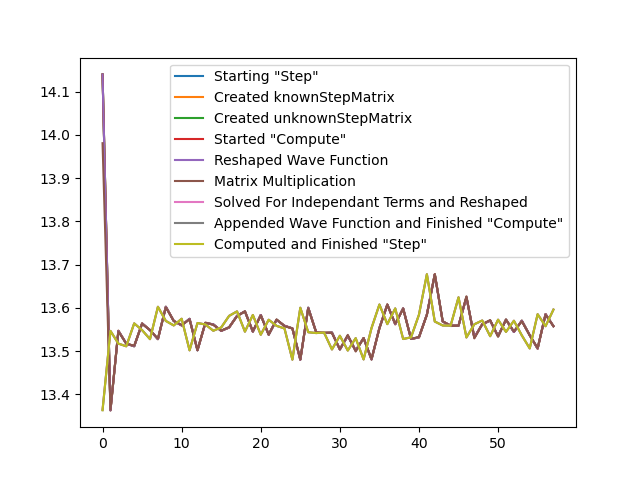

In [22]:
currentLog = copiedLogs[0]
plt.figure()
for stepLabel in logKeyList: 
    print(stepLabel)
    accelerated = np.array(currentLog[stepLabel])
    plt.plot(accelerated[1:] - accelerated[:-1], label=stepLabel)
plt.legend()

Start -> Creat
Creat -> Creat
Creat -> Start
Start -> Resha
Resha -> Matri
Matri -> Solve
Solve -> Appen
Appen -> Compu


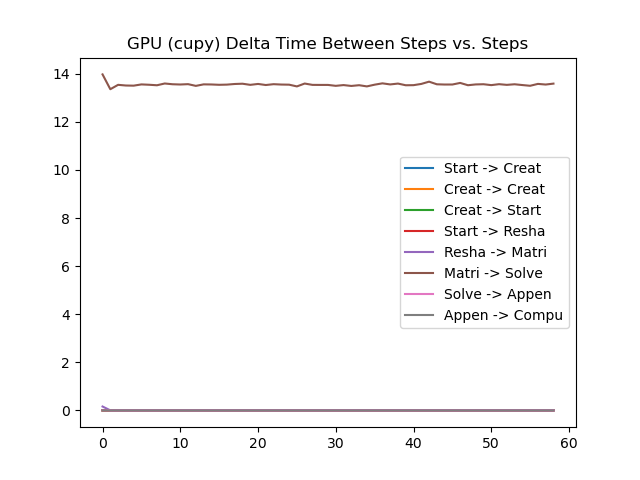

In [33]:
currentLog = copiedLogs[0]
plt.figure()
plt.title("GPU (cupy) Delta Time Between Steps vs. Steps")
for stepLabel, nextLabel in  list(zip(logKeyList[:-1], logKeyList[1:])): 
    label = stepLabel[:5] + " -> " + nextLabel[:5]
    print(label)
    acceleratedCurrent = np.array(currentLog[stepLabel])
    acceleratedNext = np.array(currentLog[nextLabel])
    plt.plot(acceleratedNext - acceleratedCurrent, label=label)
plt.legend()